## Clustering simulation evaluation

In [1]:
# SAVE 데이터 로드
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path

### 에너지 데이터 로드
SAVE = pd.read_csv('data/SAVE/power_0428.csv', index_col=0)
SAVE = SAVE.iloc[84:,:]
SAVE.index = pd.to_datetime(SAVE.index)
SAVE[SAVE == 0] = np.nan
SAVE = SAVE.loc[pd.to_datetime('2017-01-01 00:00'):,:]

helper_dict = defaultdict(list)
for col in SAVE.columns:
    helper_dict[col[2:]].append(col)

# 동일 집끼리 병합
drop_cols = []
invalid_idx_list = []
for key,value in helper_dict.items():
    if len(value) >= 2:
        valid_idx_1 = ~pd.isnull(SAVE[value[1]])

        # replace value
        SAVE[value[0]][valid_idx_1] = SAVE[value[1]][valid_idx_1]

        # delete remain
        drop_cols.append(value[1])

# drop cols
SAVE.drop(columns = drop_cols, inplace = True)

# label과 data의 column 맞춤
SAVE.columns = [c[2:] for c in SAVE.columns]

### 라벨 로드
SAVE_label = pd.read_csv('data/SAVE/save_household_survey_data_v0-3.csv', index_col = 0)
# Interviedate가 빠른 순으로 정렬
SAVE_label.sort_values('InterviewDate', inplace = True)
SAVE_label = SAVE_label.T
SAVE_label.columns = SAVE_label.columns.astype(str)

# 라벨 순서를 데이터 순서와 맞춤
valid_col = []
for col in SAVE.columns:
    if col in SAVE_label.columns:
        valid_col.append(col)

SAVE_label = SAVE_label[valid_col].T
SAVE = SAVE[valid_col]
print('Done load SAVE')
SAVE[SAVE == 0] = np.nan

# CER 데이터 로드
# %% load dataset
# start_date = pd.to_datetime('2010-09-01 00:00:00')
# end_date = pd.to_datetime('2009-12-01 23:00:00')

power_df = pd.read_csv('data/CER/power_comb_SME_included.csv')

# 0 to NaN
power_df[power_df==0] = np.nan
power_df['time'] = pd.to_datetime(power_df['time'])
power_df.set_index('time', inplace=True)

# load label
CER_label = pd.read_csv('data/CER/survey_processed_0427.csv')
CER_label['ID'] = CER_label['ID'].astype(str)
CER_label.set_index('ID', inplace=True)

CER = power_df.loc[:,CER_label.index]
del power_df
print('Done load CER')

## 기간을 6개월 한정
start_date = pd.to_datetime('2018-01-01 00:00:00')
end_date = pd.to_datetime('2018-06-30 23:45:00')

SAVE = SAVE.loc[start_date:end_date,:]

start_date = pd.to_datetime('2010-01-01 00:00:00')
end_date = pd.to_datetime('2010-06-30 23:30:00')

CER = CER.loc[start_date:end_date,:]

# Downsampling SAVE
n = SAVE.shape[0]
list_ = []
time_ = []
for i in range(0, n, 2):
    data = SAVE.iloc[i:i+2,:]
    invalid_data_idx = np.any(pd.isnull(data), axis=0)
    data = data.sum(axis=0)
    data.iloc[invalid_data_idx] = np.nan
    list_.append(data)
    time_.append(SAVE.index[i])
list_ = pd.concat(list_, axis=1).T
list_.index = time_
SAVE = list_
del list_

print(SAVE.shape)
print(CER.shape)

Done load SAVE
Done load CER
(8688, 3934)
(8688, 4232)


### invalid house processing

In [2]:
nan_ratio = pd.isnull(SAVE).sum(axis=0) / SAVE.shape[0]
invalid_idx = (nan_ratio == 1)
SAVE = SAVE.loc[:,~invalid_idx]
SAVE_label = SAVE_label.loc[~invalid_idx,:]

nan_ratio = pd.isnull(CER).sum(axis=0) / CER.shape[0]
invalid_idx = (nan_ratio == 1)
CER = CER.loc[:,~invalid_idx]
CER_label = CER_label.loc[~invalid_idx,:]

print(CER.shape)
print(CER_label.shape)


(8688, 3248)


## Partitioning clustering

In [ ]:
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans, KShape

for n_clusters in tqdm([3]):
    model_recon = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
        max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
    result_recon = model.fit_predict(CER_recon)

### Clustering 결과 load

In [432]:
import pickle

with open('clustering_result/model_dict.pickle', 'rb') as handle:
    model_dict_2 = pickle.load(handle)


# model save

In [449]:
import pickle

with open('clustering_result/CER_model_dict_0529.pickle', 'wb') as handle:
    pickle.dump(model_dict_new, handle, protocol=pickle.HIGHEST_PROTOCOL)


## daily형태로 변환

| 데이터        | home array          |
|: -------------------------- :|:--------------------------:|
| CER_rs      | home_arr |
| CER_rs_n      | home_arr_n      |
| CER_rs_recon | home_arr_n      |
| CER_rs_n_p1 | home_arr_n      |
| CER_rs_n_p2 | home_arr_n      |
| CER_rs_n_p1_recon | home_arr_n      |
| CER_rs_n_p2_recon | home_arr_n      |

In [305]:
def transform(df, sampling_interv = 24 * 2 * 7):
    n_d, n_h = df.shape
    n_w = n_d // sampling_interv
    n_d = n_w * sampling_interv
    df_rs = df.iloc[:n_d,:].values.T.reshape(n_h, -1, sampling_interv)
    return df_rs

# 3d daily 형태로 변환 (house , day , hour)
CER_rs_3d = transform(CER, 24 * 2)

# 2d 형태로 변환 (house * day , hour)
n, m, l = CER_rs_3d.shape
CER_rs = CER_rs_3d.reshape(n*m, l)
home_arr = np.repeat(np.arange(0, n), m)
invalid_idx = np.any(pd.isnull(CER_rs), axis=1)
CER_rs = CER_rs[~invalid_idx, :]
home_arr = home_arr[~invalid_idx]

# normalization
CER_rs_n = CER_rs.copy()
home_arr_n = home_arr.copy()
invalid_idx = np.nanmin(CER_rs_n, axis=1) == np.nanmax(CER_rs_n, axis=1)
CER_rs_n = CER_rs_n[~invalid_idx, :]
home_arr_n = home_arr_n[~invalid_idx]
min_ = np.nanmin(CER_rs_n, axis=1).reshape(-1,1)
max_ = np.nanmax(CER_rs_n, axis=1).reshape(-1,1)
CER_rs_n = (CER_rs_n - min_)/(max_ - min_)

# reconstruction
CER_recon = CER_rs_n * (max_ - min_) + min_ # inverse normalization

# partitioning
idx1 = list(range(0, 9*2)) + list(range(18*2, 48))
idx2 = list(range(9*2, 18*2))
CER_rs_n_p1 = CER_rs_n[:,idx1]
CER_rs_n_p2 = CER_rs_n[:,idx2]

CER_rs_n_p1_recon = CER_recon[:,idx1]
CER_rs_n_p2_recon = CER_recon[:,idx2]

CER_rs_p1 = CER_rs[:,idx1]
CER_rs_p2 = CER_rs[:,idx2]

DB index

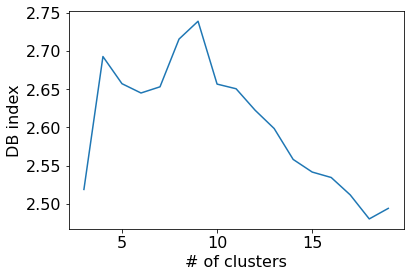

In [300]:
from sklearn.metrics import davies_bouldin_score

result_n = []
for n_clusters in range(3, 20):
    db_index = davies_bouldin_score(CER_rs, clusterig_result['euc_'+str(n_clusters)])
    result_n.append(db_index)

plt.figure()
plt.plot(range(3, 20), result_n)
plt.xlabel('# of clusters')
plt.ylabel('DB index')
plt.show()

In [366]:
CER_rs.shape

(477114, 48)

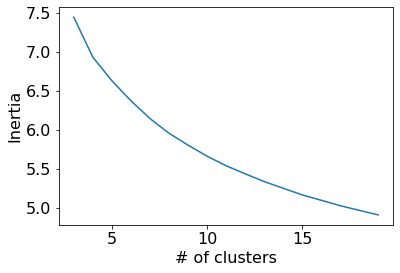

In [370]:
result_n = []
for n_clusters in range(3, 20):
    inertia = model_dict_new['euc_p2_' + str(n_clusters)].inertia_
    result_n.append(inertia)

plt.figure()
plt.plot(range(3, 20), result_n)
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.show()


In [430]:
from scipy.spatial import distance

def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = kmeans.cluster_centers_
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    #fixed
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[labels == i], centers[i,:,0].reshape(1,-1), 
             'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

for i in range(3, 20):
    print(compute_bic(model_dict_new['euc_p1_'+str(i)], CER_rs_p1))

-10777141.623183956
-10536754.362328833
-10351451.588274403
-10154378.762485266
-9984338.401914483
-9812352.384030333
-9696938.210120684
-9598084.85240659
-9508325.105701262
-9402517.526583705
-9294605.824338628
-9214642.381560344
-9135980.785122331
-9068118.292806001
-9002337.913982606
-8930944.820977615
-8864577.460201604


### Clustering 결과 기반으로 대표 부하 및 label 추출

In [180]:
label_raw = CER_label['Q13'].values
rep_load_dict = dict()
label_dict = dict()

unique_home_arr = np.unique(home_arr_n)

rep_cluster, rep_load_list, label_list = [], [], []
for h in unique_home_arr:
    idx1 = home_arr_n == h
    data = np.mean(CER_recon[idx1,:], axis=0)
    rep_load_list.append(data)
    label_list.append(label_raw[h])

rep_load_arr = np.array(rep_load_list)
rep_load_arr_ex = feature_extraction(rep_load_arr).T
rep_load_arr = np.concatenate([rep_load_arr, rep_load_arr_ex], axis=1)

rep_load_dict['6 month avg'] = rep_load_arr
label_dict['6 month avg'] = np.array(label_list)


In [280]:
label_raw = CER_label['Q13'].values
rep_load_dict = dict()
label_dict = dict()

unique_home_arr = np.unique(home_arr)

rep_cluster, rep_load_list, label_list = [], [], []
for h in unique_home_arr:
    idx1 = home_arr == h
    data = np.mean(CER_rs[idx1,:], axis=0)
    rep_load_list.append(data)
    label_list.append(label_raw[h])

rep_load_arr = np.array(rep_load_list)
rep_load_arr_ex = feature_extraction(rep_load_arr).T
rep_load_arr = np.concatenate([rep_load_arr, rep_load_arr_ex], axis=1)

rep_load_dict['6 month avg'] = rep_load_arr
label_dict['6 month avg'] = np.array(label_list)

* with partitioning

In [182]:
# N_Cluster = 9
# part = 'p1'

for part in ['all']:
    if part == 'p1':
        data = CER_rs_n_p1_recon
    elif part == 'p2':
        data = CER_rs_n_p2_recon
    elif part == 'all':
        data = CER_recon

    for N_Cluster in range(3, 14):
        unique_home_arr = np.unique(home_arr_n)
        rep_load_for_each_cluster = []
        for n_c in range(N_Cluster):
            if part != 'all':
                key = 'euc_n_'+part+'b_'+ str(N_Cluster)
            else:
                key = 'euc_n_'+ str(N_Cluster)
            idx2 = clusterig_result[key] == n_c
            rep_load_for_each_cluster.append(data[idx2,:].mean(axis=0))

        rep_cluster, rep_load_list, label_list = [], [], []
        for h in unique_home_arr:
            idx1 = home_arr_n == h
            v, c= np.unique(clusterig_result[key][idx1], return_counts=True)
            rep_c = v[np.argmax(c)]
            rep_cluster.append(rep_c)
            label_list.append(label_raw[h])
            rep_load_list.append(rep_load_for_each_cluster[rep_c])

        rep_load_arr = np.array(rep_load_list)
        rep_load_arr_ex = feature_extraction(rep_load_arr).T
        rep_load_arr = np.concatenate([rep_load_arr, rep_load_arr_ex], axis=1)

        rep_load_dict[f'kmeans-{N_Cluster} + N + {part}'] = rep_load_arr
        label_dict[f'kmeans-{N_Cluster} + N + {part}'] = np.array(label_list)

In [332]:
# N_Cluster = 9
part = 'all'

unique_home_arr = np.unique(home_arr)

for part in ['p1_','p2_']:
    if part == 'p1_':
        data = CER_rs_p1
    else:
        data = CER_rs_p2
    for N_Cluster in range(3, 20):
        rep_load_for_each_cluster = []

        for n_c in range(N_Cluster):

            key = 'euc_'+ part+str(N_Cluster)
            clusterig_result = model_dict_new[key].labels_
            idx2 = clusterig_result == n_c
            rep_load_for_each_cluster.append(data[idx2,:].mean(axis=0))

        rep_cluster, rep_load_list, label_list = [], [], []
        for h in unique_home_arr:
            idx1 = home_arr == h
            v, c= np.unique(clusterig_result[idx1], return_counts=True)
            rep_c = v[np.argmax(c)]
            rep_cluster.append(rep_c)
            label_list.append(label_raw[h])
            rep_load_list.append(rep_load_for_each_cluster[rep_c])

        rep_load_arr = np.array(rep_load_list)
        # rep_load_arr_ex = feature_extraction(rep_load_arr).T
        # rep_load_arr = np.concatenate([rep_load_arr, rep_load_arr_ex], axis=1)

        rep_load_dict[f'kmeans-{N_Cluster} + {part}'] = rep_load_arr
        label_dict[f'kmeans-{N_Cluster} + {part}'] = np.array(label_list)


In [199]:
# proposed
data_concat = []
data_concat.append(rep_load_dict['kmeans-5 + N + all'][:,:8])
data_concat.append(rep_load_dict['kmeans-3 + N + all'][:,8:11])
data_concat.append(rep_load_dict['kmeans-5 + N + all'][:,11:18])
data_concat.append(rep_load_dict['kmeans-3 + N + all'][:,18:27])
data_concat.append(rep_load_dict['6 month avg'][:,27:33])
data_concat.append(rep_load_dict['kmeans-5 + N + all'][:,33:48])
rep_load_arr = np.concatenate(data_concat, axis=1)

rep_load_arr_ex = feature_extraction(rep_load_arr).T
rep_load_arr = np.concatenate([rep_load_arr, rep_load_arr_ex], axis=1)
rep_load_dict[f'proposed'] = rep_load_arr
label_dict[f'proposed'] = label_dict['6 month avg']




### Evaluate

Evaluate partitioning

In [331]:
rep_load_dict.keys()

dict_keys(['6 month avg', 'kmeans-3 + all', 'kmeans-4 + all', 'kmeans-5 + all', 'kmeans-6 + all', 'kmeans-7 + all', 'kmeans-8 + all', 'kmeans-9 + all', 'kmeans-10 + all', 'kmeans-11 + all', 'kmeans-12 + all', 'kmeans-13 + all', 'kmeans-14 + all', 'kmeans-15 + all', 'kmeans-16 + all', 'kmeans-17 + all', 'kmeans-18 + all', 'kmeans-19 + all', 'kmeans-p1_3 + p1_', 'kmeans-p1_4 + p1_', 'kmeans-p1_5 + p1_', 'kmeans-p1_6 + p1_', 'kmeans-p1_7 + p1_', 'kmeans-p1_8 + p1_', 'kmeans-p1_9 + p1_', 'kmeans-p1_10 + p1_', 'kmeans-p1_11 + p1_', 'kmeans-p1_12 + p1_', 'kmeans-p1_13 + p1_', 'kmeans-p1_14 + p1_', 'kmeans-p1_15 + p1_', 'kmeans-p1_16 + p1_', 'kmeans-p1_17 + p1_', 'kmeans-p1_18 + p1_', 'kmeans-p1_19 + p1_', 'kmeans-p2_3 + p2_', 'kmeans-p2_4 + p2_', 'kmeans-p2_5 + p2_', 'kmeans-p2_6 + p2_', 'kmeans-p2_7 + p2_', 'kmeans-p2_8 + p2_', 'kmeans-p2_9 + p2_', 'kmeans-p2_10 + p2_', 'kmeans-p2_11 + p2_', 'kmeans-p2_12 + p2_', 'kmeans-p2_13 + p2_', 'kmeans-p2_14 + p2_', 'kmeans-p2_15 + p2_', 'kmeans-p2_1

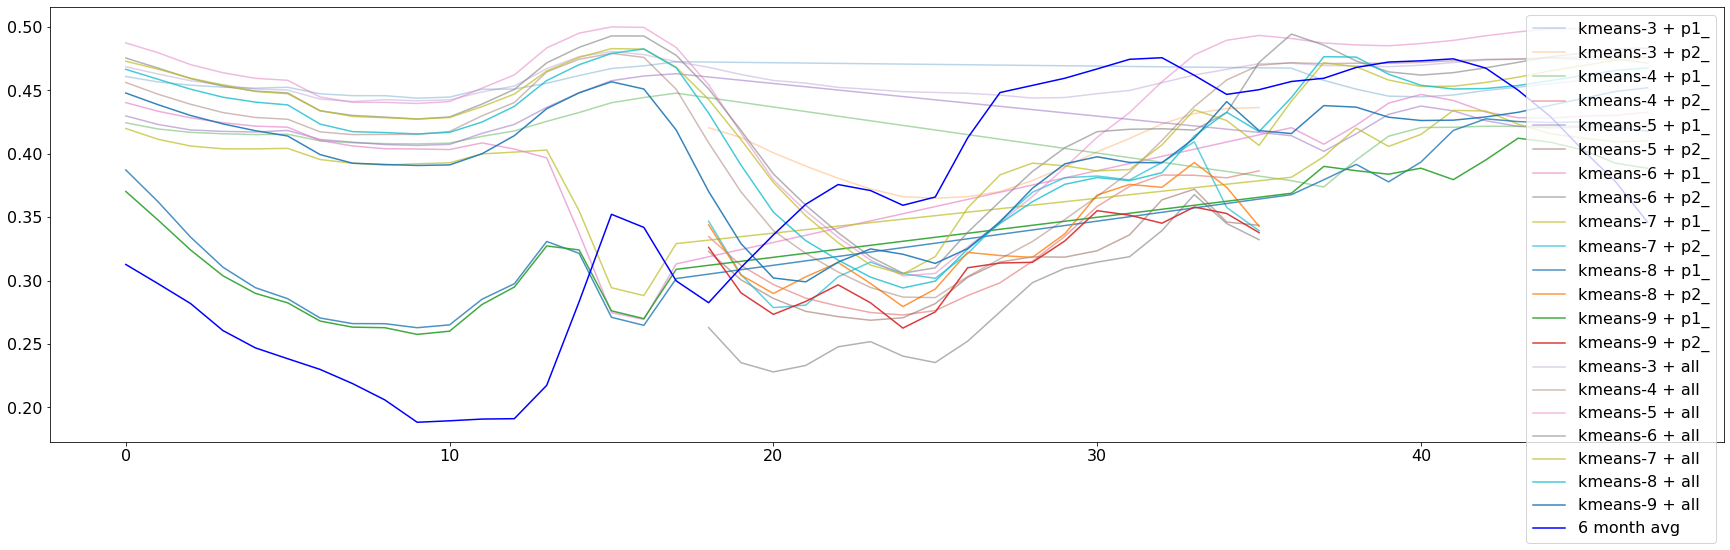

In [347]:
idx1_1 = list(range(0, 9*2))
idx1_2 = list(range(18*2, 48))
idx1 = idx1_1 + idx1_2

idx2 = list(range(9*2, 18*2))
plt.figure(figsize = (30,8))

for N_Cluster in range(3, 10):
    for part in ['p1_', 'p2_']:
        key = f'kmeans-{N_Cluster} + {part}'

        data = rep_load_dict[key]
        label = label_dict[key]

        corr_list = []
        for j in range(data.shape[1]):
            corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
        corr_list = np.array(corr_list)
        if 'p1' in key:
            plt.plot(idx1, np.abs(corr_list),label = key, alpha = N_Cluster * 0.1)

        elif 'p2' in key:
            plt.plot(idx2, np.abs(corr_list),label = key, alpha = N_Cluster * 0.1)

for N_Cluster in range(3, 10):
    for part in ['all']:
        key = f'kmeans-{N_Cluster} + {part}'

        data = rep_load_dict[key]
        label = label_dict[key]

        corr_list = []
        for j in range(data.shape[1]):
            corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
        corr_list = np.array(corr_list)
        plt.plot(np.abs(corr_list)[:48],label = key, alpha = N_Cluster * 0.1)


key = '6 month avg'
data = rep_load_dict[key]
label = label_dict[key]
corr_list = []
for j in range(data.shape[1]):
    corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])

plt.plot(np.abs(corr_list)[:48], label = key, color = 'b')

plt.legend()
plt.show()



part 1

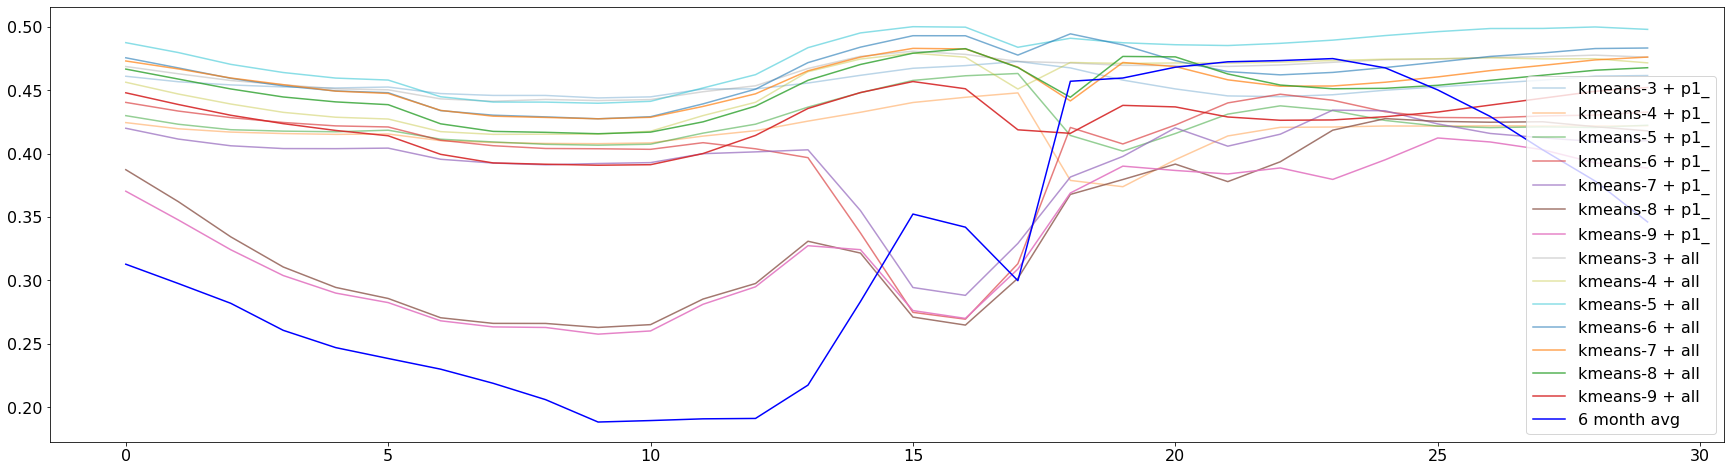

In [354]:
idx1_1 = list(range(0, 9*2))
idx1_2 = list(range(18*2, 48))
idx1 = idx1_1 + idx1_2

idx2 = list(range(9*2, 18*2))
plt.figure(figsize = (30,8))

for N_Cluster in range(3, 10):
    for part in ['p1_']:
        key = f'kmeans-{N_Cluster} + {part}'

        data = rep_load_dict[key]
        label = label_dict[key]

        corr_list = []
        for j in range(data.shape[1]):
            corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
        corr_list = np.array(corr_list)
        plt.plot(np.abs(corr_list),label = key, alpha = N_Cluster * 0.1)

for N_Cluster in range(3, 10):
    for part in ['all']:
        key = f'kmeans-{N_Cluster} + {part}'

        data = rep_load_dict[key]
        label = label_dict[key]

        corr_list = []
        for j in range(data.shape[1]):
            corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
        corr_list = np.array(corr_list)
        plt.plot(np.abs(corr_list)[idx1],label = key, alpha = N_Cluster * 0.1)


key = '6 month avg'
data = rep_load_dict[key]
label = label_dict[key]
corr_list = []
for j in range(data.shape[1]):
    corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])

plt.plot(np.abs(corr_list)[idx1], label = key, color = 'b')

plt.legend()
plt.show()


part 2

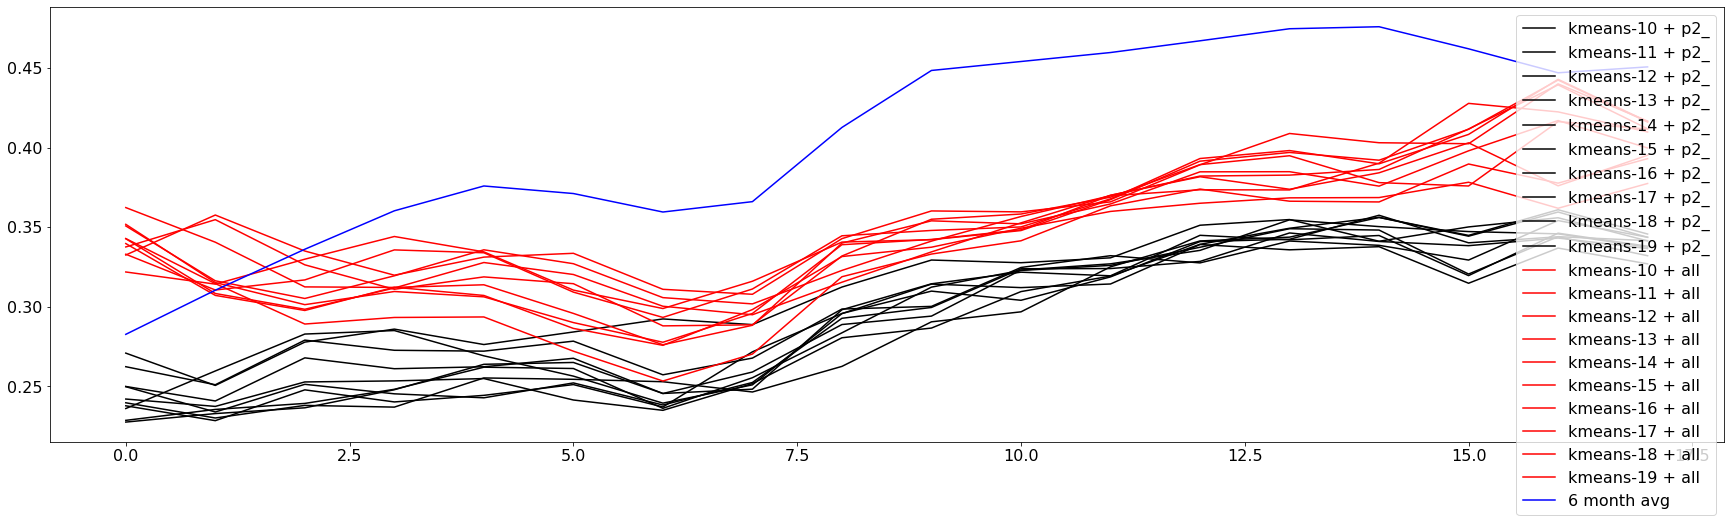

In [360]:
idx1_1 = list(range(0, 9*2))
idx1_2 = list(range(18*2, 48))
idx1 = idx1_1 + idx1_2

idx2 = list(range(9*2, 18*2))
plt.figure(figsize = (30,8))

for N_Cluster in range(10, 20):
    for part in ['p2_']:
        key = f'kmeans-{N_Cluster} + {part}'

        data = rep_load_dict[key]
        label = label_dict[key]

        corr_list = []
        for j in range(data.shape[1]):
            corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
        corr_list = np.array(corr_list)
        plt.plot(np.abs(corr_list),label = key, color = 'k')

for N_Cluster in range(10, 20):
    for part in ['all']:
        key = f'kmeans-{N_Cluster} + {part}'

        data = rep_load_dict[key]
        label = label_dict[key]

        corr_list = []
        for j in range(data.shape[1]):
            corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
        corr_list = np.array(corr_list)
        plt.plot(np.abs(corr_list)[idx2],label = key, color = 'r')


key = '6 month avg'
data = rep_load_dict[key]
label = label_dict[key]
corr_list = []
for j in range(data.shape[1]):
    corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])

plt.plot(np.abs(corr_list)[idx2], label = key, color = 'b')

plt.legend()
plt.show()


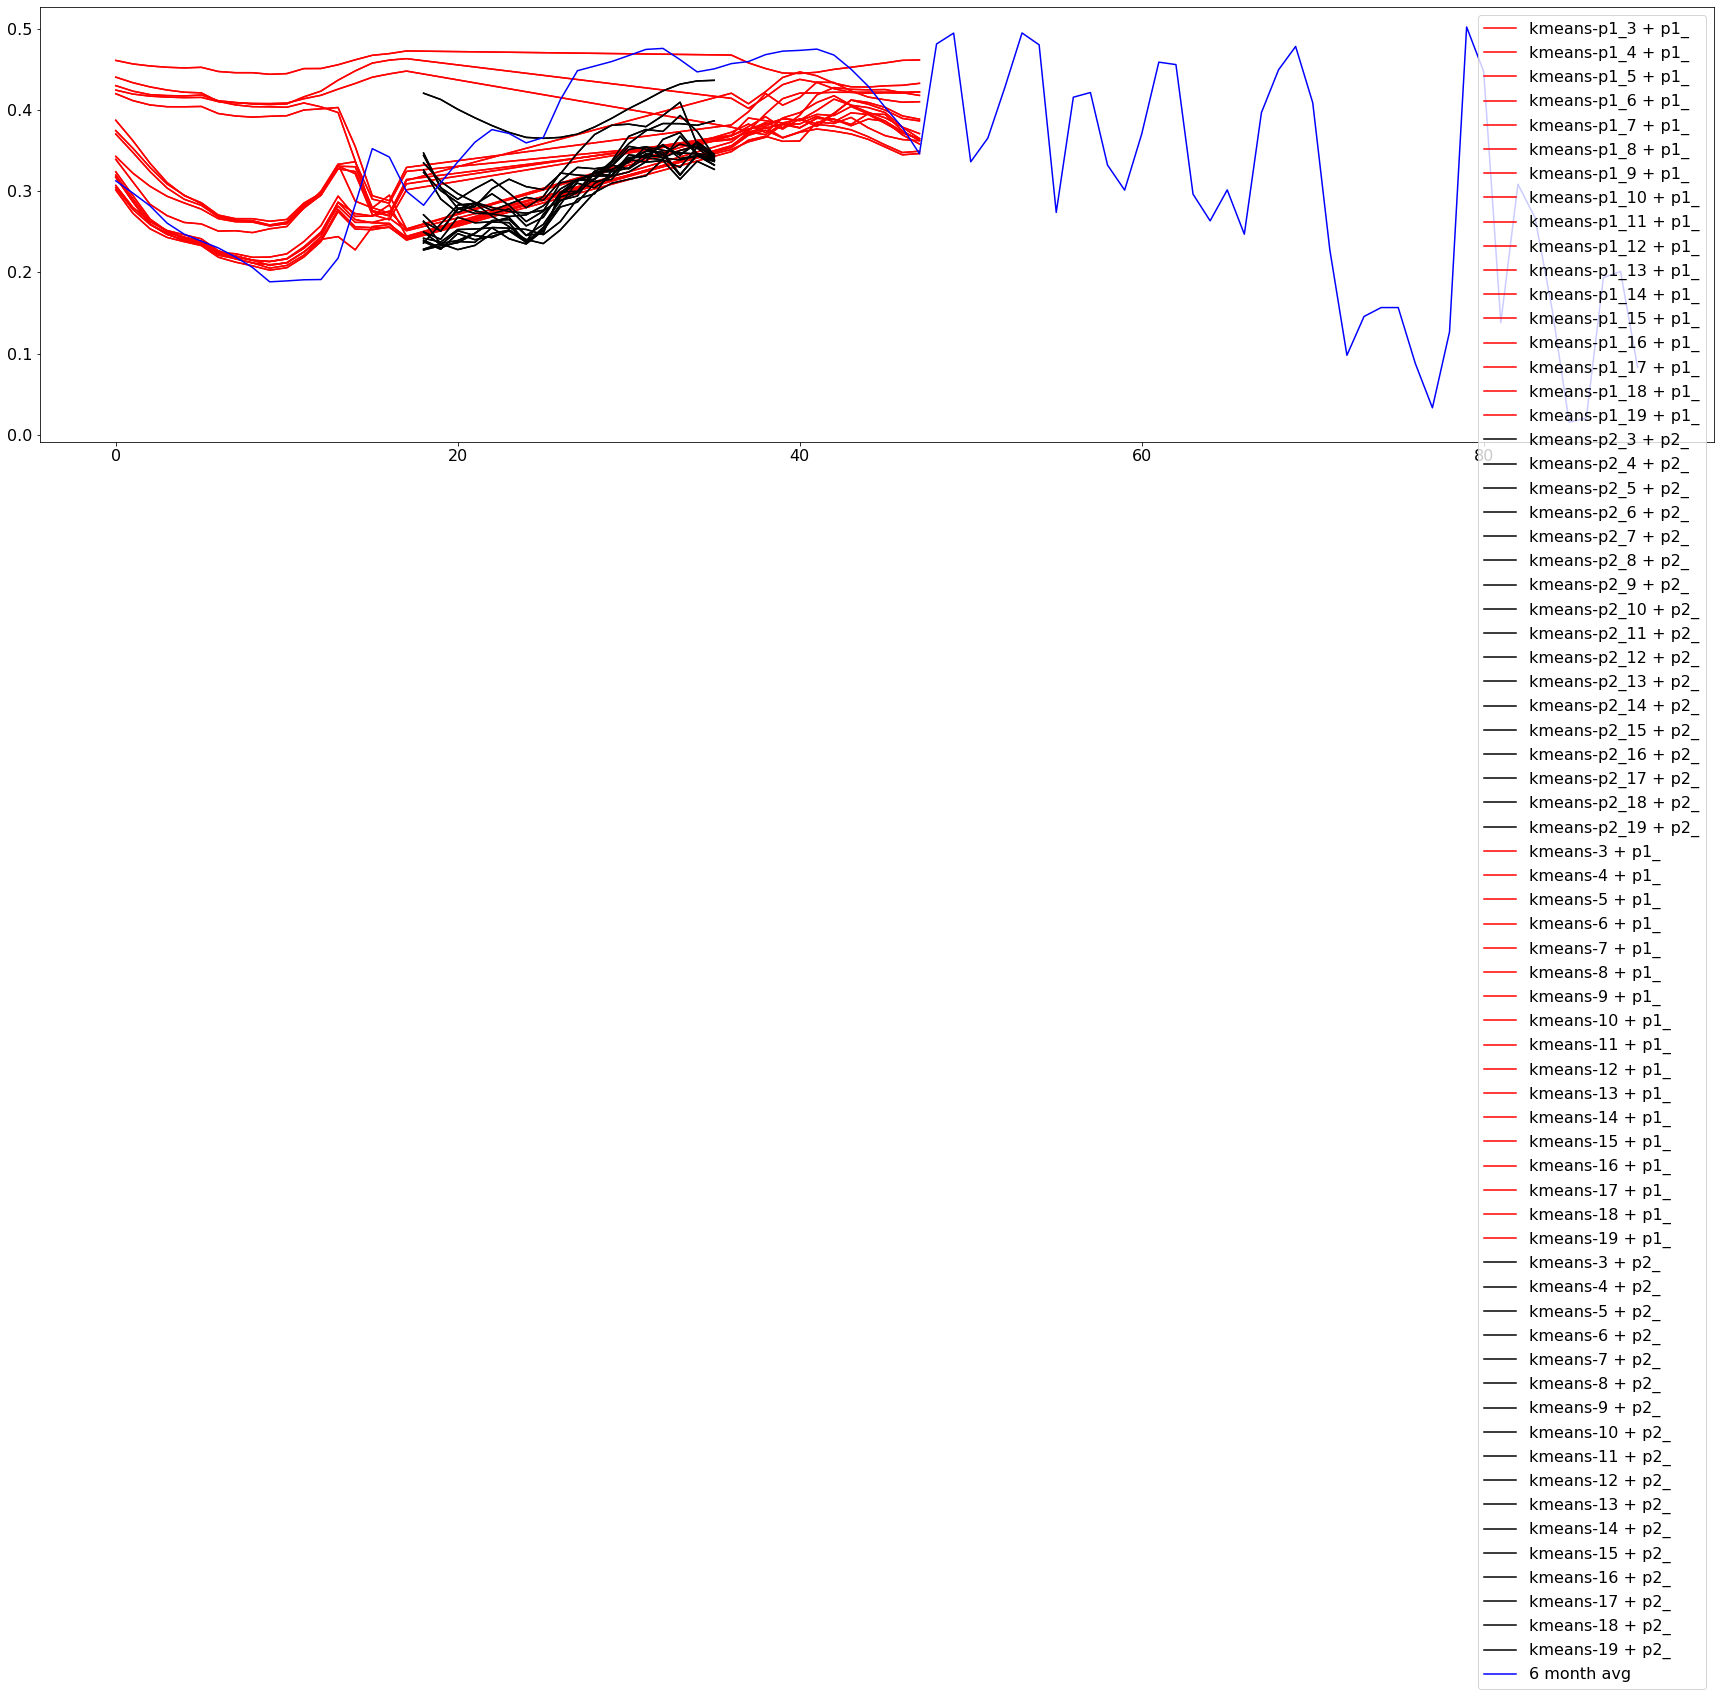

In [338]:
idx1 = list(range(0, 9*2)) + list(range(18*2, 48))
idx2 = list(range(9*2, 18*2))

plt.figure(figsize = (30,8))
for key in rep_load_dict.keys():
    if 'p' not in key:
        continue
    data = rep_load_dict[key]
    label = label_dict[key]
    corr_list = []
    for j in range(data.shape[1]):
        corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
    corr_list = np.array(corr_list)
    if 'p1' in key:
        plt.plot(idx1, np.abs(corr_list), label = key, color = 'r')
    elif 'p2' in key:
        plt.plot(idx2, np.abs(corr_list), label = key, color = 'k')

plt.legend()
plt.show()

/home/ubuntu/anaconda3/envs/mskim/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ubuntu/anaconda3/envs/mskim/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


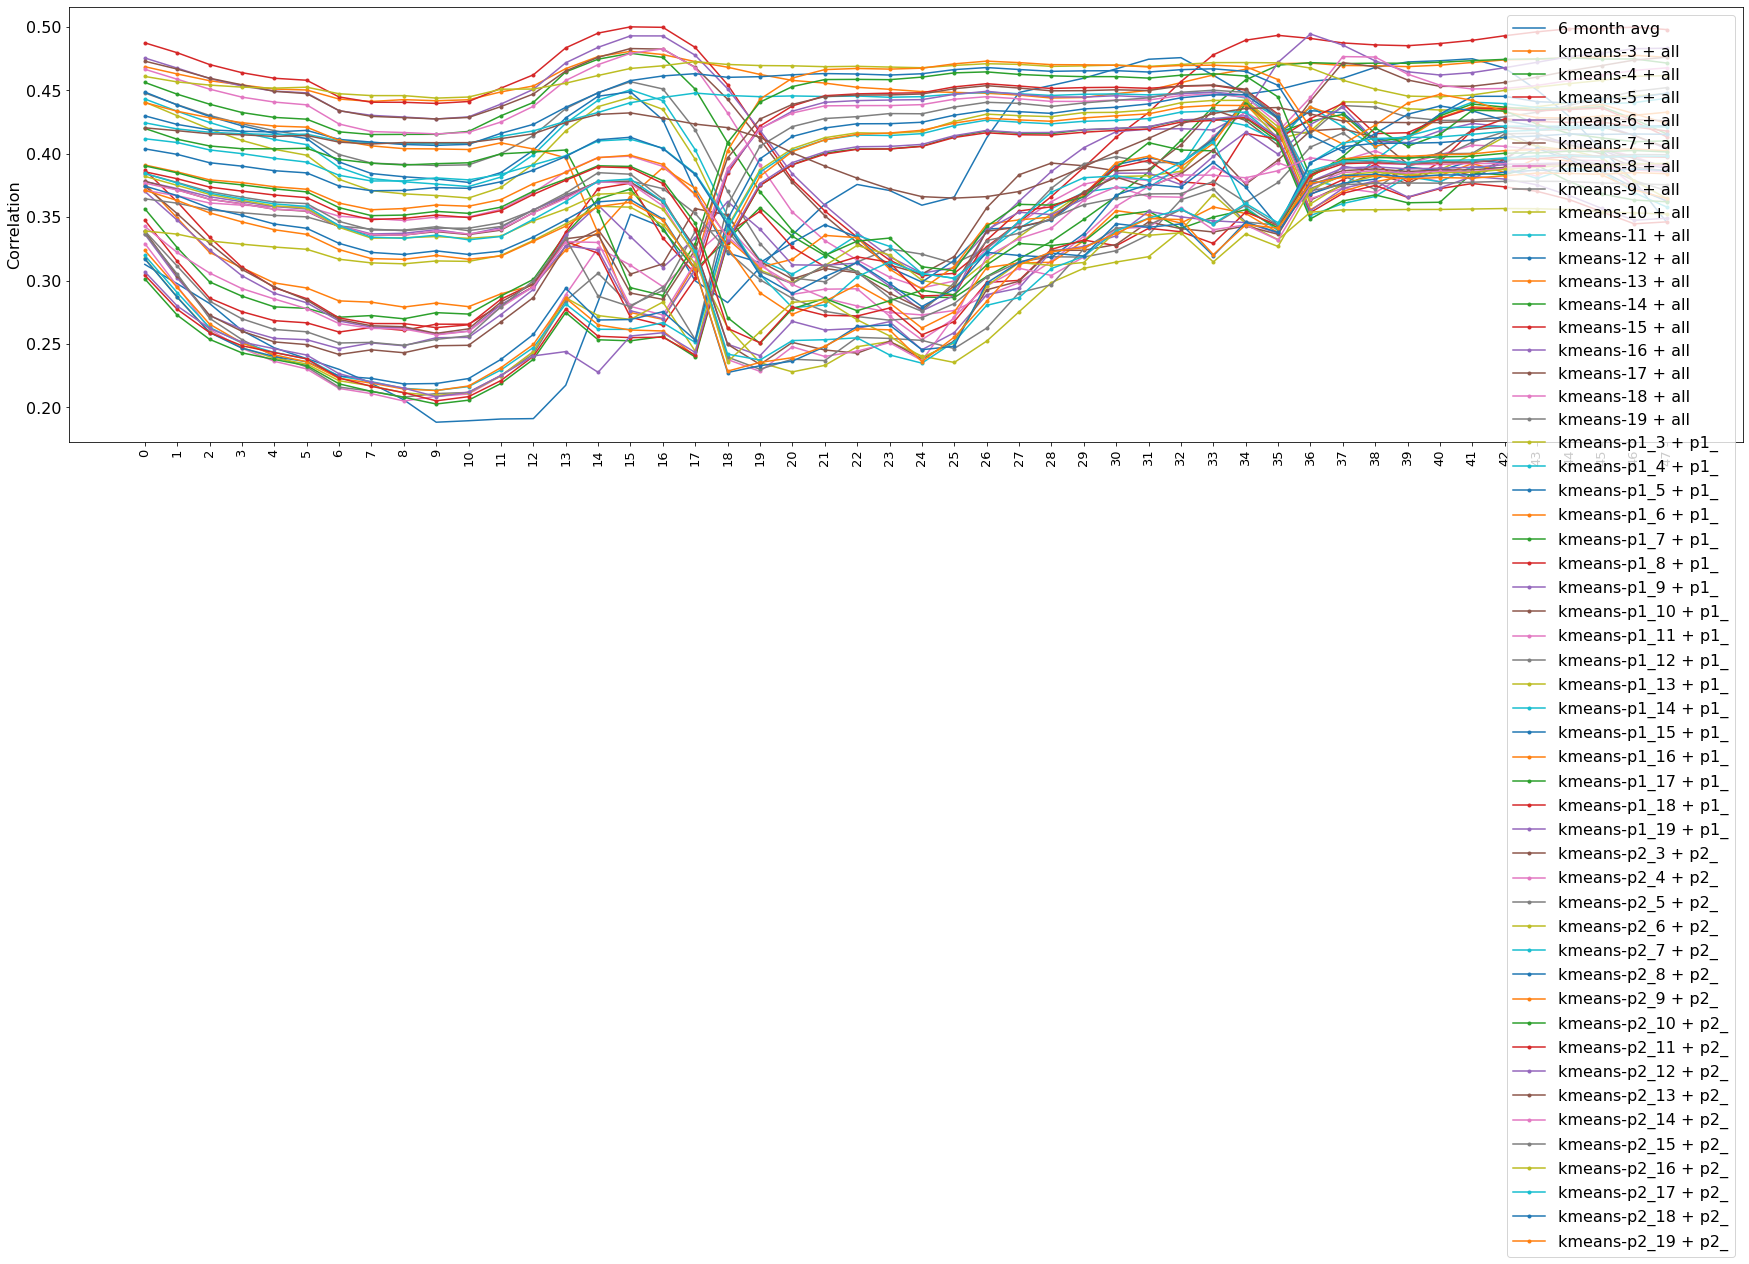

In [322]:
idx1 = list(range(0, 9*2)) + list(range(18*2, 48))
idx2 = list(range(9*2, 18*2))

# sorting
key = '6 month avg'
data = rep_load_dict[key]
label = label_dict[key]
corr_list = []
for j in range(data.shape[1]):
    corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
# idx = np.argsort(np.abs(corr_list))[::-1]
# idx = idx[:60]
idx = range(48)

plt.figure(figsize = (30,8))
for key in rep_load_dict.keys():
    data = rep_load_dict[key]
    label = label_dict[key]
    corr_list = []
    for j in range(data.shape[1]):
        corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
    corr_list = np.array(corr_list)
    if 'proposed' in key:
        plt.bar(range(len(corr_list[idx])), np.abs(corr_list[idx]), label = key)
    elif 'avg' in key:
        plt.plot(range(len(corr_list[idx])), np.abs(corr_list[idx]), label = key)
    else:
        plt.plot(range(len(corr_list[idx])), np.abs(corr_list[idx]), '.-',label = key)
plt.legend()
# plt.xlabel('Hour')
# plt.xticks(range(len(corr_list[idx])), idx, rotation = 30, fontsize  = 10)
plt.xticks(range(len(corr_list[idx])), np.array(feature_names)[idx], rotation = 90, fontsize  = 13)
# tick.label.set_fontsize(14) 
plt.ylabel('Correlation')
# plt.ylim(0.3, 0.55)
plt.show()

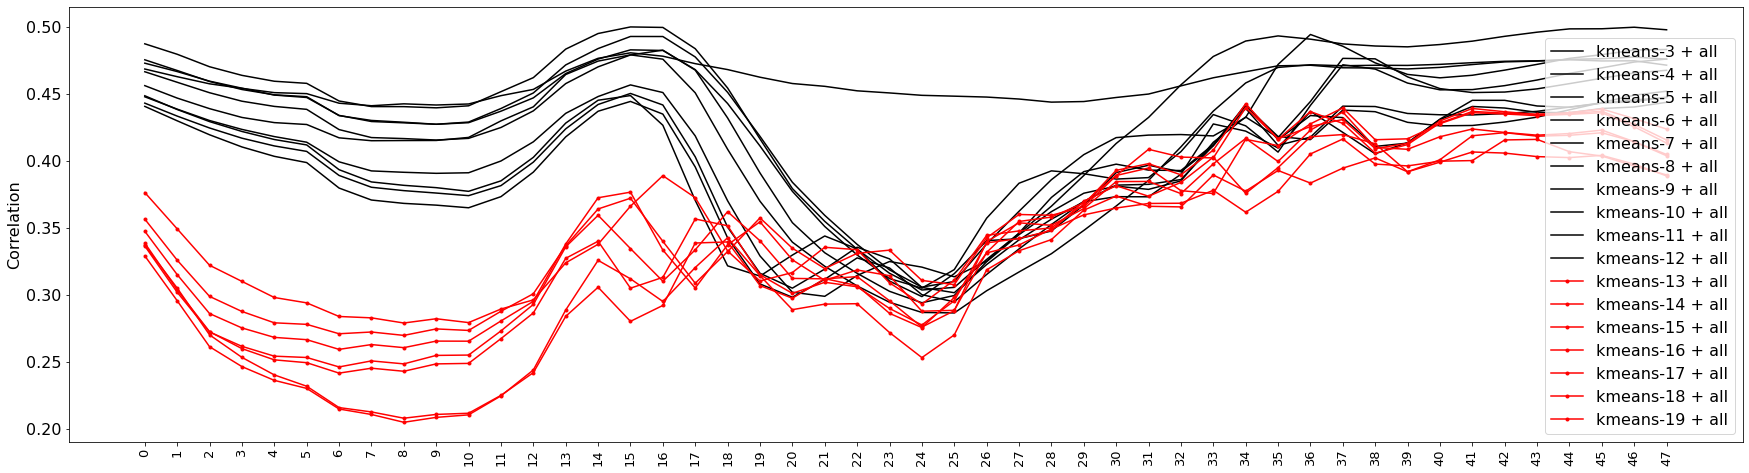

In [304]:
idx1 = list(range(0, 9*2)) + list(range(18*2, 48))
idx2 = list(range(9*2, 18*2))

# sorting
key = '6 month avg'
data = rep_load_dict[key]
label = label_dict[key]
corr_list = []
for j in range(data.shape[1]):
    corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
# idx = np.argsort(np.abs(corr_list))[::-1]
# idx = idx[:60]
idx = range(48)

plt.figure(figsize = (30,8))
for i in range(3, 20):
    key = 'kmeans-'+str(i)+' + all'
    data = rep_load_dict[key]
    label = label_dict[key]
    corr_list = []
    for j in range(data.shape[1]):
        corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
    corr_list = np.array(corr_list)
    if i < 13:
        plt.plot(range(len(corr_list[idx])), np.abs(corr_list[idx]), label = key, color = 'k')
    else:
        plt.plot(range(len(corr_list[idx])), np.abs(corr_list[idx]), '.-',label = key, color = 'r')
plt.legend()
# plt.xlabel('Hour')
# plt.xticks(range(len(corr_list[idx])), idx, rotation = 30, fontsize  = 10)
plt.xticks(range(len(corr_list[idx])), np.array(feature_names)[idx], rotation = 90, fontsize  = 13)
# tick.label.set_fontsize(14) 
plt.ylabel('Correlation')
# plt.ylim(0.3, 0.55)
plt.show()

### Feature별로 가장 우세한 군집

In [201]:
key_list = list(rep_load_dict.keys())
n, m = len(key_list), len(feature_names)
corr_result = np.zeros((n, m))

for i in range(n):
    key = key_list[i]

    data = rep_load_dict[key]
    label = label_dict[key]
    for j in range(m):
        corr_result[i, j] = np.corrcoef(data[:,j], np.ravel(label))[0,1]


In [202]:
corr_result_df = pd.DataFrame(columns = feature_names)
for j, f in enumerate(feature_names):
    corr_result_df[f] = np.array(key_list)[np.argsort(corr_result[:,j])[::-1][:3]]

In [206]:
corr_result_df.iloc[0,:48]

0               proposed
1               proposed
2               proposed
3               proposed
4               proposed
5               proposed
6               proposed
7               proposed
8               proposed
9               proposed
10              proposed
11              proposed
12              proposed
13              proposed
14              proposed
15              proposed
16              proposed
17              proposed
18              proposed
19              proposed
20              proposed
21              proposed
22              proposed
23              proposed
24              proposed
25              proposed
26              proposed
27              proposed
28              proposed
29              proposed
30              proposed
31              proposed
32              proposed
33              proposed
34              proposed
35              proposed
36    kmeans-6 + N + all
37              proposed
38              proposed
39              proposed


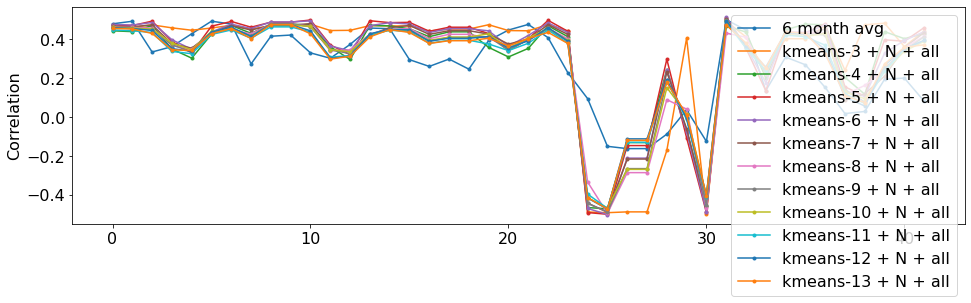

In [149]:
idx1 = list(range(0, 9*2)) + list(range(18*2, 48))
idx2 = list(range(9*2, 18*2))

plt.figure(figsize = (16,4))
for key in rep_load_dict.keys():
    data = rep_load_dict[key]
    label = label_dict[key]
    corr_list = []
    for j in range(data.shape[1]):
        corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
    if 'p1' in key:
        # plt.plot(idx1, corr_list, '.-',label = key)
        pass
    elif 'p2' in key:
        # plt.plot(idx2, corr_list, '.-',label = key)
        pass
    else:
        plt.plot(corr_list[48:], '.-',label = key)
        pass
plt.legend()
# plt.xlabel('Hour')
# plt.xticks(range(48)[::6], (np.array(range(48))/2)[::6].astype(int))
plt.ylabel('Correlation')
plt.show()

Feature extraction 후에 평가

In [144]:
feature_names = ['c_total','c_day','c_morning','c_forenoon','c_noon','c_afternoon','c_evening','c_night',\
'c_total_max','c_day_max','c_morning_max','c_forenoon_max','c_noon_max','c_afternoon_max','c_evening_max','c_night_max',\
    'c_total_min','c_day_min','c_morning_min','c_forenoon_min','c_noon_min','c_afternoon_min','c_evening_min','c_night_min',\
    'r_mean_max','r_min_mean','r_forenoon_noon','r_afternoon_noon','r_evening_noon','r_noon_total','r_night_day',\
        'P_above_0','P_above_1','P_above_2',\
            'c_total_var','c_day_var','c_morning_var','c_forenoon_var','c_noon_var','c_afternoon_var','c_evening_var','c_night_var']
feature_names = np.array(list(range(48))).astype(str).tolist() + feature_names
feature_names = np.array(feature_names)

In [189]:
def feature_extraction(profile_allday):
    features = []
    '''
        mean features
    '''
    # 1. mean P, daily, all day : c_total
    feature = np.mean(profile_allday, axis=1)
    features.append(feature)

    # 4. mean P, 6 ~ 22 : c_day
    feature = np.mean(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    # 5. mean P, 6 ~ 8.5: c_morning
    feature = np.mean(profile_allday[:, 2 * 6:2 * 8 + 1], axis=1)
    features.append(feature)

    # 6. mean P, 8.5 ~ 12: c_forenoon
    feature = np.mean(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1)
    features.append(feature)

    # 7. mean P, 12 ~ 14.5: c_noon
    feature = np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 8. mean P, 14.5 ~ 18: c_afternoon
    feature = np.mean(profile_allday[:, 2 * 14 + 1:2 * 18], axis=1)
    features.append(feature)

    # 9. mean P, 18 ~ 24: c_evening
    feature = np.mean(profile_allday[:, 2 * 18:2 * 24], axis=1)
    features.append(feature)

    # 10. mean P, 00 ~ 6: c_night
    feature = np.mean(profile_allday[:, :2 * 6], axis=1)
    features.append(feature)

    '''
        max features
    '''
    # 1. max P, daily, all day : c_total
    feature = np.max(profile_allday, axis=1)
    features.append(feature)

    # 4. max P, 6 ~ 22 : c_day
    feature = np.max(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    # 5. max P, 6 ~ 8.5: c_morning
    feature = np.max(profile_allday[:, 2 * 6:2 * 8 + 1], axis=1)
    features.append(feature)

    # 6. max P, 8.5 ~ 12: c_forenoon
    feature = np.max(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1)
    features.append(feature)

    # 7. max P, 12 ~ 14.5: c_noon
    feature = np.max(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 8. max P, 14.5 ~ 18: c_afternoon
    feature = np.max(profile_allday[:, 2 * 14 + 1:2 * 18], axis=1)
    features.append(feature)

    # 9. max P, 18 ~ 24: c_evening
    feature = np.max(profile_allday[:, 2 * 18:2 * 24], axis=1)
    features.append(feature)

    # 10. max P, 00 ~ 6: c_night
    feature = np.max(profile_allday[:, :2 * 6], axis=1)
    features.append(feature)
    '''
        min
    '''
    # 1. min P, daily, all day : c_total
    feature = np.min(profile_allday, axis=1)
    features.append(feature)

    # 4. min P, 6 ~ 22 : c_day
    feature = np.min(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    # 5. min P, 6 ~ 8.5: c_morning
    feature = np.min(profile_allday[:, 2 * 6:2 * 8 + 1], axis=1)
    features.append(feature)

    # 6. min P, 8.5 ~ 12: c_forenoon
    feature = np.min(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1)
    features.append(feature)

    # 7. min P, 12 ~ 14.5: c_noon
    feature = np.min(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 8. min P, 14.5 ~ 18: c_afternoon
    feature = np.min(profile_allday[:, 2 * 14 + 1:2 * 18], axis=1)
    features.append(feature)

    # 9. min P, 18 ~ 24: c_evening
    feature = np.min(profile_allday[:, 2 * 18:2 * 24], axis=1)
    features.append(feature)

    # 10. min P, 00 ~ 6: c_night
    feature = np.min(profile_allday[:, :2 * 6], axis=1)
    features.append(feature)
    '''
        ratios
    '''
    # 1. mean P over max P
    feature = np.mean(profile_allday, axis=1) / np.max(profile_allday, axis=1)
    features.append(feature)

    # 2. min P over mean P
    feature = np.min(profile_allday, axis=1) / np.mean(profile_allday, axis=1)
    features.append(feature)

    # 3. c_forenoon / c_noon
    feature = np.mean(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1) / \
              np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 4. c_afternoon / c_noon
    feature = np.mean(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1) / \
              np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 5. c_evening / c_noon
    feature = np.mean(profile_allday[:, 2 * 18:2 * 24], axis=1) / \
              np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 6. c_noon / c_total
    feature = np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1) / \
              np.mean(profile_allday, axis=1)
    features.append(feature)

    # 7. c_night / c_day
    feature = np.mean(profile_allday[:, :2 * 6], axis=1) / \
              np.mean(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    '''
        temporal properties
    '''
    # 1. P > 0.5
    feature = (profile_allday > 0.5).mean(axis=1)
    features.append(feature)

    # 1. P > 1
    feature = (profile_allday > 1).mean(axis=1)
    features.append(feature)

    # 1. P > 2
    feature = (profile_allday > 2).mean(axis=1)
    features.append(feature)

    '''
        statistical properties
    '''
    # 1. var P, daily, all day : c_total
    feature = np.var(profile_allday, axis=1)
    features.append(feature)

    # 4. var P, 6 ~ 22 : c_day
    feature = np.var(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    # 5. var P, 6 ~ 8.5: c_morning
    feature = np.var(profile_allday[:, 2 * 6:2 * 8 + 1], axis=1)
    features.append(feature)

    # 6. var P, 8.5 ~ 12: c_forenoon
    feature = np.var(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1)
    features.append(feature)

    # 7. var P, 12 ~ 14.5: c_noon
    feature = np.var(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 8. var P, 14.5 ~ 18: c_afternoon
    feature = np.var(profile_allday[:, 2 * 14 + 1:2 * 18], axis=1)
    features.append(feature)

    # 9. var P, 18 ~ 24: c_evening
    feature = np.var(profile_allday[:, 2 * 18:2 * 24], axis=1)
    features.append(feature)

    # 10. var P, 00 ~ 6: c_night
    feature = np.var(profile_allday[:, :2 * 6], axis=1)
    features.append(feature)

    return np.array(features)

### 다시 돌릴 것

In [307]:
model_dict_new = dict()

In [310]:
for n_clusters in tqdm(range(2, 20)):
    # 1. KMeans
    model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
        max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
    result = model.fit_predict(CER_rs_p1)
    model_dict_new['euc_p1_' + str(n_clusters)] = model

    model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
        max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
    result = model.fit_predict(CER_rs_p2)
    model_dict_new['euc_p2_' + str(n_clusters)] = model

.810 --> 6.810 --> 6.810 --> 
 22%|██▏       | 4/18 [1:44:35<7:26:35, 1913.93s/it]
8.807 --> 6.963 --> 6.780 --> 6.709 --> 6.672 --> 6.649 --> 6.633 --> 6.622 --> 6.613 --> 6.606 --> 6.601 --> 6.597 --> 6.594 --> 6.592 --> 6.589 --> 6.587 --> 6.585 --> 6.584 --> 6.583 --> 6.581 --> 6.580 --> 6.579 --> 6.578 --> 6.577 --> 6.576 --> 6.576 --> 6.575 --> 6.574 --> 6.574 --> 6.573 --> 6.572 --> 6.572 --> 6.571 --> 6.571 --> 6.571 --> 6.570 --> 6.570 --> 6.570 --> 6.570 --> 6.570 --> 6.570 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.569 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 6.568 --> 
 28%|██▊       | 5/18 [2:48:29<9:24:42, 2606.36s/it]
8.517 --> 6.798 --> 6.631 --> 6.550 --> 6.503 --> 6.477 --> 6.460 --> 6.449 --> 6.441 --> 6.435 --> 6.430 --> 6.426 --> 6.423 --> 6.420 --> 6.417 --> 6.4

In [312]:
model_dict_new.keys()

dict_keys(['euc_p1_2', 'euc_p2_2', 'euc_p1_3', 'euc_p2_3', 'euc_p1_4', 'euc_p2_4', 'euc_p1_5', 'euc_p2_5', 'euc_p1_6', 'euc_p2_6', 'euc_p1_7', 'euc_p2_7', 'euc_p1_8', 'euc_p2_8', 'euc_p1_9', 'euc_p2_9', 'euc_p1_10', 'euc_p2_10', 'euc_p1_11', 'euc_p2_11', 'euc_p1_12', 'euc_p2_12', 'euc_p1_13', 'euc_p2_13', 'euc_p1_14', 'euc_p2_14', 'euc_p1_15', 'euc_p2_15', 'euc_p1_16', 'euc_p2_16', 'euc_p1_17', 'euc_p2_17', 'euc_p1_18', 'euc_p2_18', 'euc_p1_19', 'euc_p2_19'])

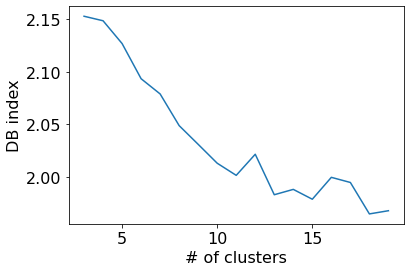

In [314]:
from sklearn.metrics import davies_bouldin_score

result_n = []
for n_clusters in range(3, 20):
    db_index = davies_bouldin_score(CER_rs_p2, model_dict_new['euc_p2_' + str(n_clusters)].labels_)
    result_n.append(db_index)

plt.figure()
plt.plot(range(3, 20), result_n)
plt.xlabel('# of clusters')
plt.ylabel('DB index')
plt.show()

In [315]:
for n_clusters in tqdm(range(13, 20)):
    # 1. KMeans
    model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
        max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
    result = model.fit_predict(CER_rs)
    model_dict_new['euc_' + str(n_clusters)] = model
    break

  0%|          | 0/7 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [316]:
import pickle

with open('model_dict_p.pickle', 'wb') as handle:
    pickle.dump(model_dict_new, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
print('살려줘...')

살려줘...
